# Imaging demonstration

### This script works through the high level arl interface to crocodile, making a fake data set and then deconvolving it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import sys, os
sys.path.append('../..') 
print(sys.path)
print(os.getcwd())

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy import units as u

from matplotlib import pyplot as plt

from arl.image_deconvolution import deconvolve_cube
from arl.visibility_operations import create_visibility
from arl.fourier_transforms import *
from arl.skymodel_operations import create_skymodel_from_image, add_component_to_skymodel, create_skycomponent, \
    find_skycomponent
from arl.image_operations import show_image, import_image_from_fits, export_image_to_fits
from arl.test_support import filter_configuration, create_named_configuration, replicate_image

['', '/Library/Frameworks/Python.framework/Versions/3.5/lib/python35.zip', '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5', '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/plat-darwin', '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/lib-dynload', '/Users/timcornwell/env/lib/python3.5/site-packages', '/Users/timcornwell/env/lib/python3.5/site-packages/IPython/extensions', '/Users/timcornwell/.ipython', '../..']
/Users/timcornwell/Code/crocodile/examples/arl


### Construct a VLA configuration and then shrink it to match our test image.

filter_configuration: No filter implemented yet
visibility_operations.create_visibility: Created 22113 rows


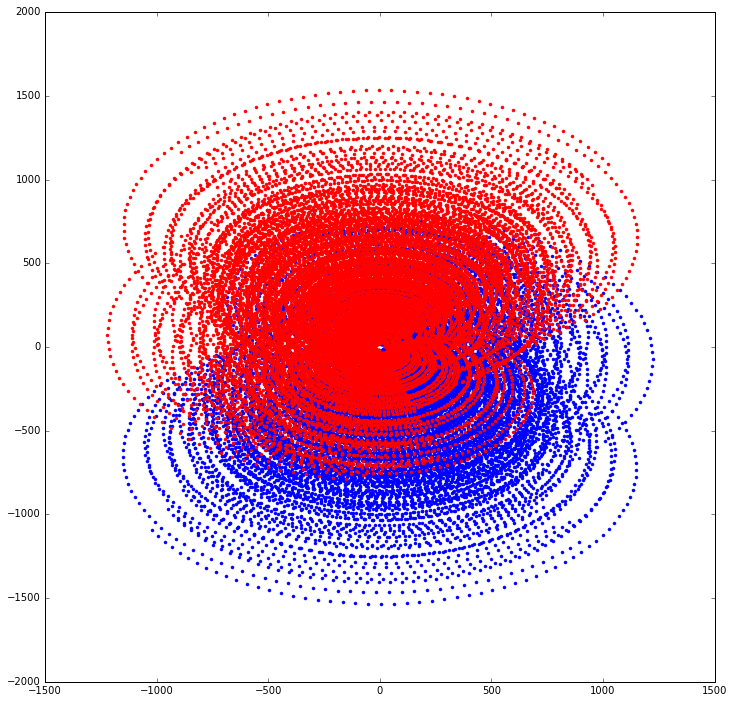

In [2]:
parameters = {}

vlaa = filter_configuration(create_named_configuration('VLAA'), parameters)
vlaa.data['xyz']=vlaa.data['xyz']/10.0


# We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

times = numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(0.0*u.rad, u.rad*numpy.pi/4, frame='icrs', equinox=2000.0)
vt = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)


# Plot the synthesized uv coverage, including for MFS

plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

### Read the venerable test image, constructing an image

image_operations.import_image_from_fits: Max, min in /Users/timcornwell/Code/crocodile//./data/models/M31.MOD = 1.006458, 0.000000


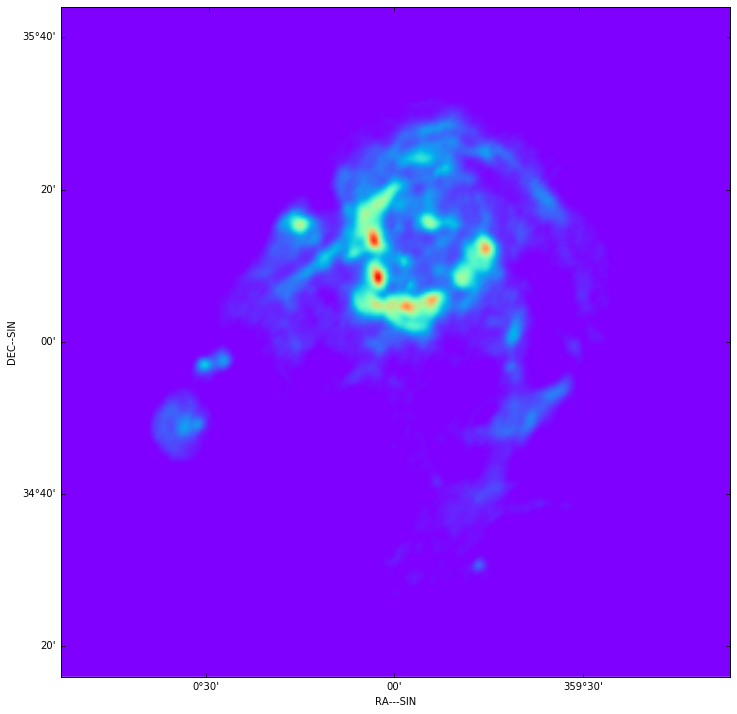

replicate_image: replicating shape (256, 256) to (1, 4, 256, 256)
ICRS
2000.0


In [3]:
m31image = import_image_from_fits("./data/models/M31.MOD")
fig = plt.figure()
cellsize=180.0*0.0001/numpy.pi
m31image.wcs.wcs.cdelt[0]=-cellsize
m31image.wcs.wcs.cdelt[1]=+cellsize
m31image.wcs.wcs.radesys='ICRS'
m31image.wcs.wcs.equinox=2000.00

# Show the model image
fig.add_subplot(111, projection=m31image.wcs)
plt.imshow(m31image.data, origin='lower', cmap='rainbow')
plt.xlabel('RA---SIN')
plt.ylabel('DEC--SIN')
plt.show()

# This image is only 2 dimensional. We need extra axes frequency and stokes.

m31image4D=replicate_image(m31image, shape=[1, 1, 4, len(frequency)])
m31sm = create_skymodel_from_image(m31image4D)

# We need a linear reference frame to inset a model source. This is a bit involved die to the Astropy way of doing
# things
wall = m31image.wcs
wall.wcs.radesys='ICRS'
wall.wcs.equinox=2000.00
print(wall.wcs.radesys)
print(wall.wcs.equinox)
sc=pixel_to_skycoord(128, 128, wall, 1, 'wcs')
compabsdirection=SkyCoord("-1.0d", "37.0d", frame='icrs', equinox=2000.0)
pixloc = skycoord_to_pixel(compabsdirection, wall, 1)
scrt = pixel_to_skycoord(pixloc[0], pixloc[1], wall, 1, 'wcs')
sof=sc.skyoffset_frame()
compreldirection = compabsdirection.transform_to(sof)

# Create a skycomponent and add it to the skymodel
comp1= create_skycomponent(flux=numpy.array([[1.0, 0.0, 0.0, 0.0]]), frequency=frequency, direction=compreldirection)
m31sm=add_component_to_skymodel(m31sm, comp1)

### Now we can predict_visibility the visibility from this skymodel

fourier_transformscreate_wcs_from_visibility: Parsing kwargs to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
fourier_transforms.create_wcs_from_visibility: uvmax = 1533.754509 lambda
fourier_transforms.create_wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
fourier_transforms.create_wcs_from_visibility: Cellsize          = 0.000100 radians, 0.005730 degrees
fourier_transforms.predict_visibility: Predicting Visibility from sky model images
fourier_transforms.predict_visibility: Image cellsize 0.000100 radians
fourier_transforms.predict_visibility: Field of view 0.025600 radians
fourier_transforms.predict_visibility: Making w-kernel cache of 12 kernels
fourier_transforms.predict_visibility: Predicting from image channel 0, polarisation 0
fourier_transforms.predict_visibility: Predicting from image channel 0, polar

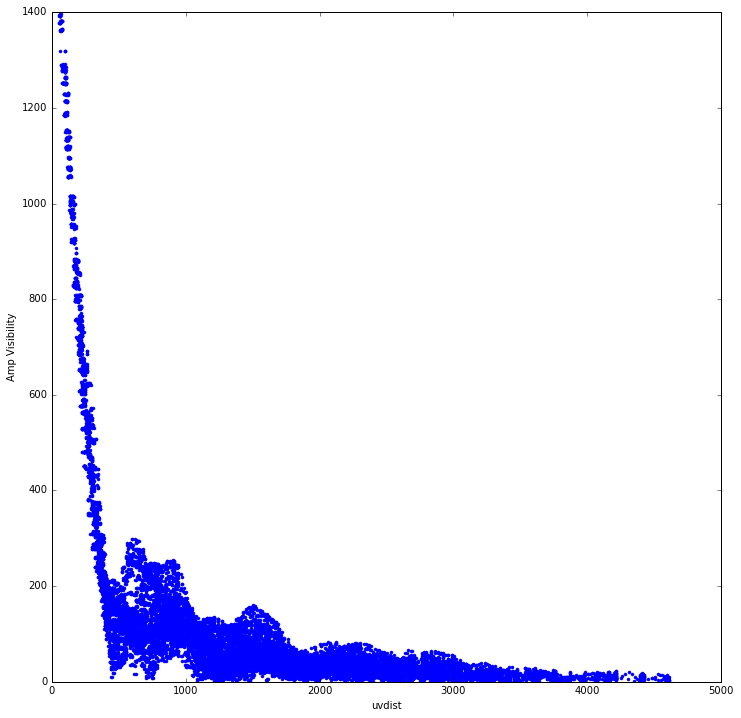

In [4]:
parameters = {'wstep':100.0, 'npixel':256, 'cellsize':0.0001}
vt = predict_visibility(vt, m31sm, parameters)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

### Make the dirty image and point spread function

fourier_transforms.invert_visibility: Inverting Visibility to make dirty and psf
fourier_transformscreate_wcs_from_visibility: Parsing kwargs to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
fourier_transforms.create_wcs_from_visibility: uvmax = 1533.754509 lambda
fourier_transforms.create_wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
fourier_transforms.create_wcs_from_visibility: Cellsize          = 0.000100 radians, 0.005730 degrees
fourier_transforms.invert_visibility: Specified npixel=512, cellsize = 0.000100 rad, FOV = 0.051200 rad
fourier_transforms.invert_visibility: Making w-kernel cache of 39 kernels
fourier_transforms.invert_visibility: Inverting channel 0, polarisation 0
fourier_transforms.invert_visibility: Inverting channel 0, polarisation 1
fourier_transforms.invert_visibility: Inverting channel 

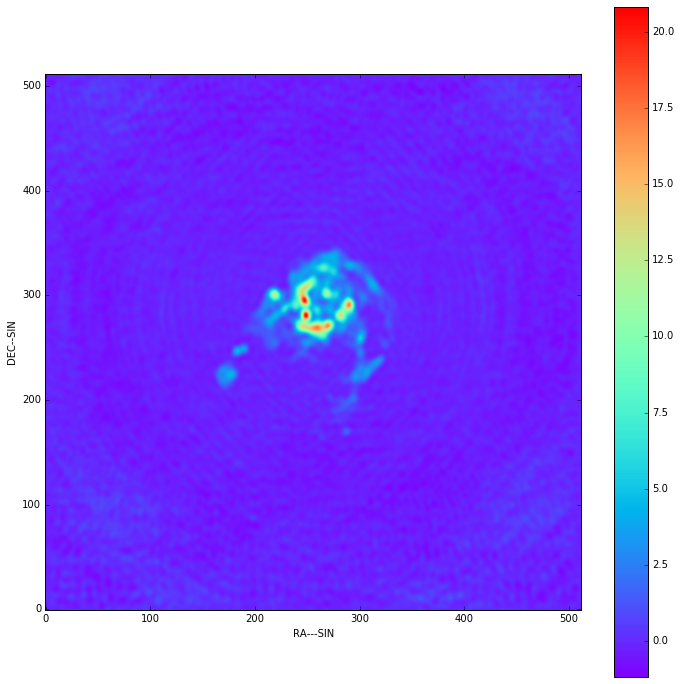

In [5]:
parameters={}
parameters['npixel']=512
parameters['cellsize']=0.0001
parameters['wstep']=30.0
dirty, psf, sumwt = invert_visibility(vt, parameters)
show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sum of weights = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sum of weights = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, 'temp_dirty.fits')
export_image_to_fits(psf, 'temp_psf.fits')
m31compnew = find_skycomponent(dirty)

### Deconvolve using clean

clean.clean: Processing pol 0, channel 0
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 20.8251914472 at (281, 248)
Coupling matrix =
 [[ 1.          0.98254714  0.76027592  0.19824986]
 [ 0.98254714  0.96555194  0.74886582  0.19720193]
 [ 0.76027592  0.74886582  0.60082915  0.18228196]
 [ 0.19824986  0.19720193  0.18228196  0.10628513]]
Max abs in dirty Image = 20.825191
Start of minor cycle
This minor cycle will stop at 100 iterations or peak < 0.208251914472
Minor cycle 0, peak [ 17.18728983  17.12492822  16.27034915  12.36866438] at [268, 260, 3]
Minor cycle 10, peak [ 7.63029298  7.59835038  7.16228706  5.47100467] at [326, 267, 3]
Minor cycle 20, peak [ 4.3166189   4.29489324  4.0014179   2.90478914] at [279, 218, 3]
Minor cycle 30, peak [ 4.30240934  4.2778072   3.91617755  1.97903513] at [247, 185, 3]
Minor cycle 40, peak [ 3.57242166  3.53376612  3.03722138  1.61348499] at [291, 240, 3]
Minor cycle 50, peak [ 2.36798999  2.35098999  2.12138038  1.24056276] at [247, 299, 3]
Mi

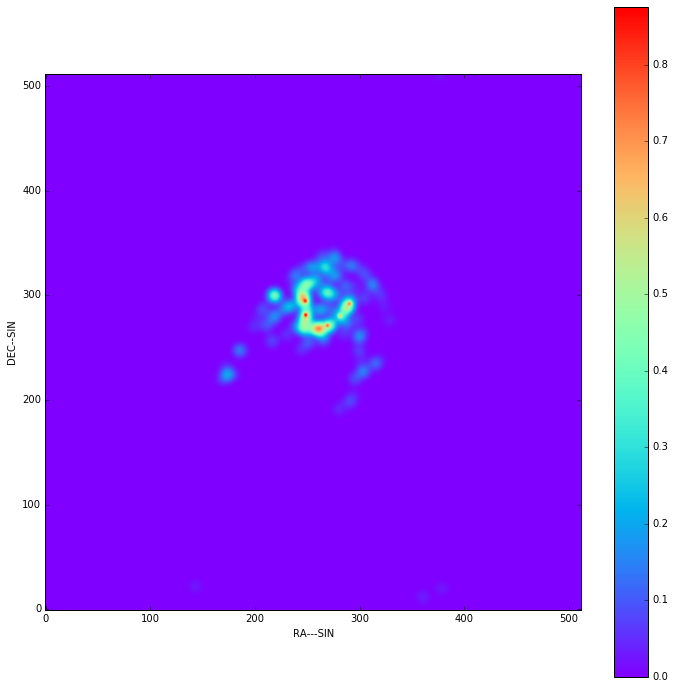

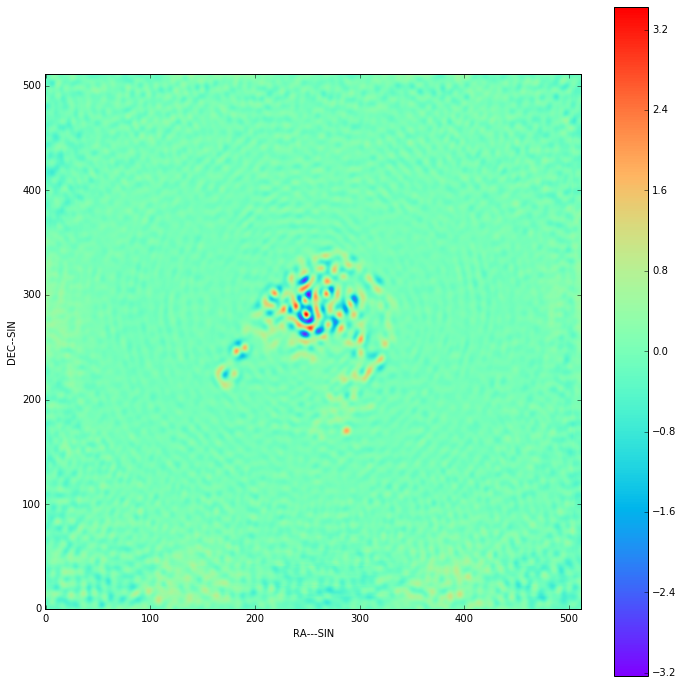

In [6]:
parameters={'niter':100, 'threshold':0.001, 'fracthresh':0.01}
comp, residual = deconvolve_cube(dirty, psf, parameters)

# Show the results

fig=show_image(comp)
fig=show_image(residual)

### Predict the visibility of the model

fourier_transformscreate_wcs_from_visibility: Parsing kwargs to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
fourier_transforms.create_wcs_from_visibility: uvmax = 1533.754509 lambda
fourier_transforms.create_wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
fourier_transforms.create_wcs_from_visibility: Cellsize          = 0.000163 radians, 0.009339 degrees
fourier_transforms.predict_visibility: Predicting Visibility from sky model images
fourier_transforms.predict_visibility: Image cellsize 0.000100 radians
fourier_transforms.predict_visibility: Field of view 0.025600 radians
fourier_transforms.predict_visibility: Making w-kernel cache of 39 kernels
fourier_transforms.predict_visibility: Predicting from image channel 0, polarisation 0
fourier_transforms.predict_visibility: Predicting from image channel 0, polar

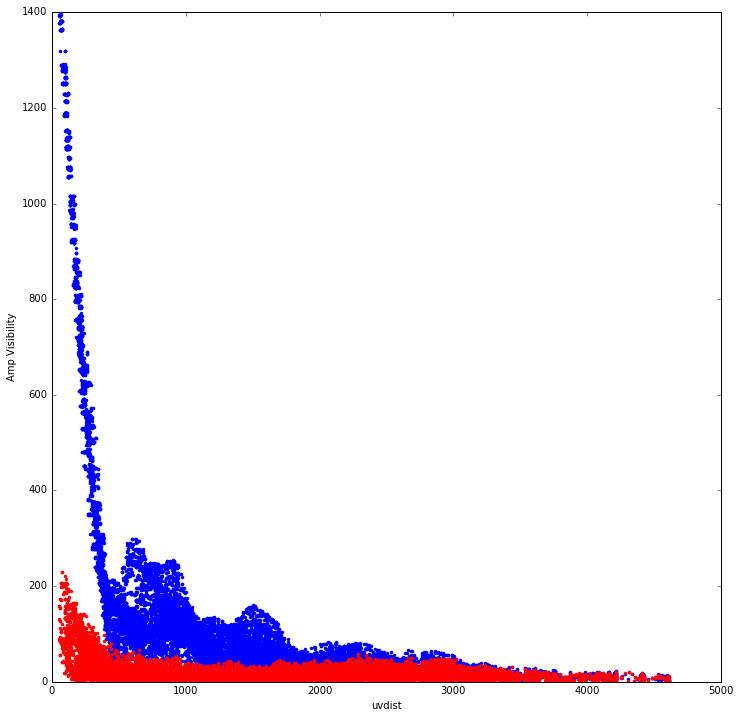

In [7]:
parameters={'wstep':30.0}
vt = predict_visibility(vt, m31sm, parameters)
modelsm=create_skymodel_from_image(comp)
vtmodel = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)
vtmodel.data = vt.data.copy()
vtmodel=predict_visibility(vtmodel, modelsm, parameters)


# Now we will plot the original visibility and the residual visibility.

uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()